In [0]:
from keras.datasets import cifar10
from keras.models import Sequential, Model
from keras.utils import to_categorical
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, LeakyReLU
from keras.layers import Dropout, Activation, BatchNormalization, Reshape
from keras.layers import UpSampling2D, Conv2DTranspose, Input, UpSampling2D
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from plotnine import *

## Data Import

In [0]:
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

In [0]:
images = np.concatenate((train_images, test_images), axis = 0)
images = images[np.argwhere(labels == 8)[:,0]].astype('float32') / 255

### Plotting Examples of All 10 Classes

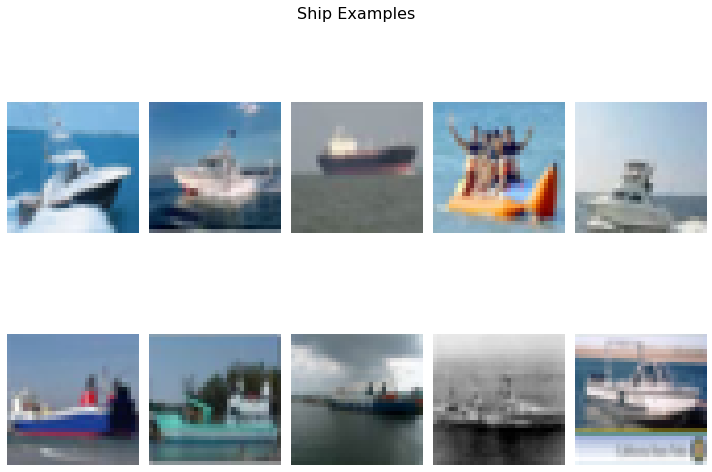

In [0]:
plt.rcParams["figure.figsize"] = (10, 8)
fig, axs = plt.subplots(2,5)
fig.suptitle('Ship Examples', fontsize = 16)

for i in range(5):
    axs[0, i].imshow(images[i])
    axs[1, i].imshow(images[i + 5])
    axs[0, i].axis('off')
    axs[1, i].axis('off')

fig.tight_layout()
plt.show()

### Initializations

In [0]:
row_num, col_num, channels = 32, 32, 3
latent_dim = 100

### Generator

In [0]:
def build_generator():
    mod = Sequential()

    ### Generate Random Noise ###
    mod.add( Dense(8 * 8 * 128, input_dim = latent_dim) )
    mod.add( Reshape((8, 8, 128)) )

    ### Convolution Transpose Layers ###
    mod.add( UpSampling2D() )
    mod.add( Conv2D(256, 3, padding = 'same') )
    mod.add( BatchNormalization(momentum = 0.9) )
    mod.add( Activation('relu') )
    mod.add( UpSampling2D() )
    mod.add( Conv2D(128, 3, padding = 'same') )
    mod.add( BatchNormalization(momentum = 0.9) )
    mod.add( Activation('relu') )
    mod.add( Conv2D(channels, 3, padding = 'same') )
    mod.add( Activation('sigmoid') )

    ### Generator Summary ###
    print("Generator Summary")
    mod.summary()
    print(" ")

    noise = Input(shape = (latent_dim,))
    img = mod(noise)

    return( Model(noise, img) )

### Discriminator

In [0]:
def build_discriminator():
    mod = Sequential()

    ### Convolutional Layers ###
    mod.add( Conv2D(32, (3, 3), input_shape = (row_num, col_num, channels), padding = 'same') ) 
    mod.add( LeakyReLU(alpha = 0.2) )
    mod.add( MaxPooling2D((2, 2)) )
    mod.add( Conv2D(64, (3, 3), padding = 'same') ) 
    mod.add( LeakyReLU(alpha = 0.2) )
    mod.add( MaxPooling2D((2, 2)) )
    mod.add( Conv2D(128, (3, 3), padding = 'same') )
    mod.add( LeakyReLU(alpha = 0.2) )
    mod.add( MaxPooling2D((2, 2)) )
    mod.add( Conv2D(256, (3, 3), padding = 'same') )
    mod.add( LeakyReLU(alpha = 0.2) )

    ### Multi Layer Perceptron ###
    mod.add( Flatten() ) 
    mod.add( Dense(128, activation = 'relu') )
    mod.add( Dense(1, activation = 'sigmoid') )

    ### Discriminator Summary ###
    print("Discriminator Summary")
    mod.summary()
    print(" ")
    
    img = Input(shape = (row_num, col_num, channels))
    validity = mod(img)
    
    return( Model(img, validity) )

### Combined Model

In [0]:
### Compile Discriminator ###
discriminator = build_discriminator()
discriminator.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                      metrics = ['accuracy'])

### Feeding Noise to Generator ###
generator = build_generator() # Do I need (row_num, col_num, channels)
z = Input(shape = (latent_dim,))
img = generator(z)

### Only Training Generator ###
discriminator.trainable = False

### Feeding Fake Image to Discriminator ###
valid = discriminator(img)

### Stacking Discriminator and Generator (Adversarial Model)
combined = Model(z, valid)
combined.compile(loss = 'binary_crossentropy', 
                 optimizer = 'adam')

Discriminator Summary
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (No

### Model Training

In [0]:
batch_size = 64 # setting batch size
valid, fake = np.ones((batch_size, 1)), np.zeros((batch_size, 1))
test_noise = np.random.normal(0, 1, (10, latent_dim)) # num output, z
gen_img_store = []
d_loss_store, d_acc_store, g_loss_store = [], [], []
for epoch in range(10001):
    # Select random images
    idx = np.random.randint(0, images.shape[0], batch_size)
    imgs = images[idx]
    
    # Generate images based on random noise
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    gen_imgs = generator.predict(noise)
    
    # Train discriminator (Real Image = 1, Fake = 0)
    discriminator_loss_real = discriminator.train_on_batch(imgs, valid)
    discriminator_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
    discriminator_loss = 0.5 * np.add(discriminator_loss_real, discriminator_loss_fake)
    
    # Train generator
    generator_loss = combined.train_on_batch(noise, valid)
    
    d_loss = np.round(discriminator_loss[0], 3)
    d_accuracy = np.round(100 * discriminator_loss[1], 3)
    g_loss = np.round(generator_loss, 3)
    d_loss_store.append(d_loss)
    d_acc_store.append(d_accuracy)
    g_loss_store.append(g_loss)
    
    if epoch % 500 == 0:
        gen_images = generator.predict(test_noise)
        gen_img_store.append(gen_images)
        # Print Losses
        print("Epoch = {}, D Loss: {}, D Accuracy: {}, G Loss: {}".format(
            epoch, d_loss, d_accuracy, g_loss))

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch = 0, D Loss: 0.8009999990463257, D Accuracy: 33.594, G Loss: 0.5870000123977661
Epoch = 500, D Loss: 0.08699999749660492, D Accuracy: 98.438, G Loss: 3.4820001125335693
Epoch = 1000, D Loss: 0.10700000077486038, D Accuracy: 96.875, G Loss: 2.065999984741211
Epoch = 1500, D Loss: 0.4490000009536743, D Accuracy: 80.469, G Loss: 1.6299999952316284
Epoch = 2000, D Loss: 0.02800000086426735, D Accuracy: 99.219, G Loss: 5.01800012588501
Epoch = 2500, D Loss: 0.22200000286102295, D Accuracy: 89.844, G Loss: 2.9570000171661377
Epoch = 3000, D Loss: 0.21799999475479126, D Accuracy: 92.188, G Loss: 2.388000011444092
Epoch = 3500, D Loss: 0.6809999942779541, D Accuracy: 71.094, G Loss: 1.684000015258789
Epoch = 4000, D Loss: 0.24400000274181366, D Accuracy: 90.625, G Loss: 5.073999881744385
Epoch = 4500, D Loss: 0.11999999731779099, D Accuracy: 94.531, G Loss: 3.9089999198913574
Epoch = 5000, D Loss: 0.13699999451637268, D Accuracy: 96.875, G Loss: 3.131999969482422
Epoch = 5500, D Loss: 0.

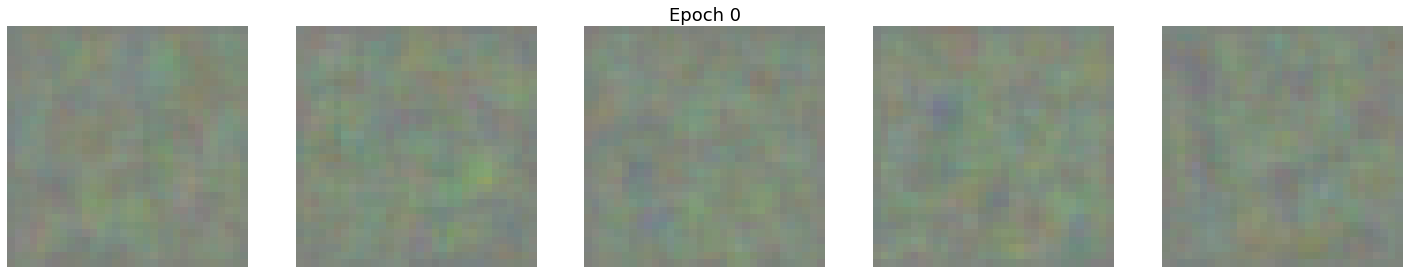

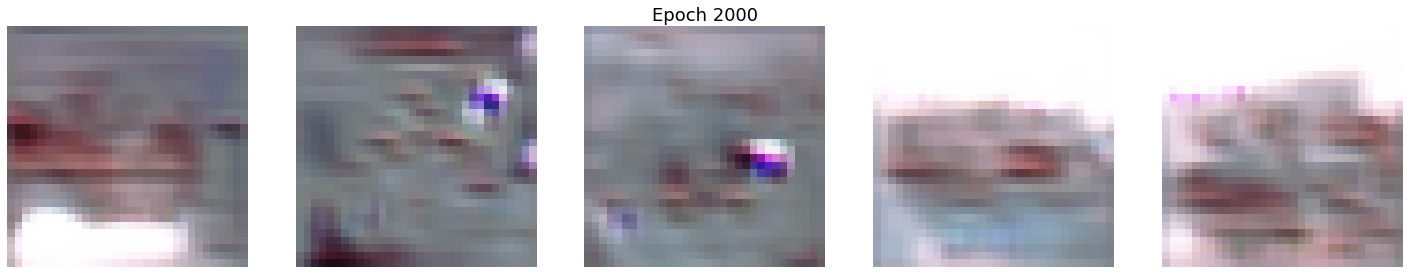

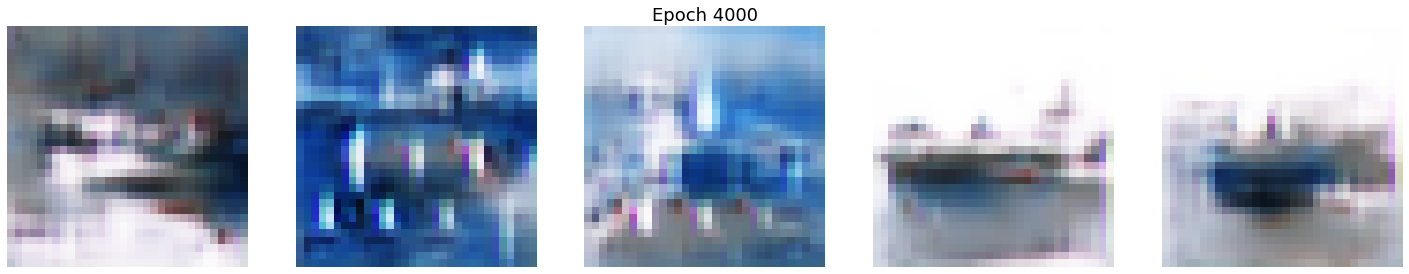

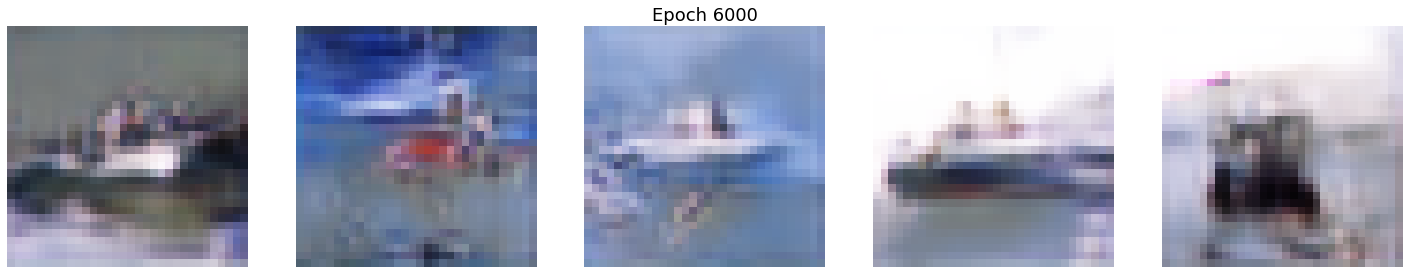

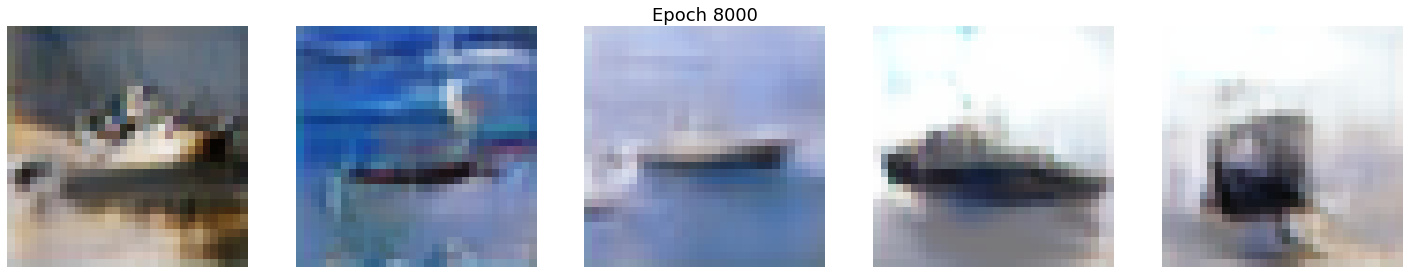

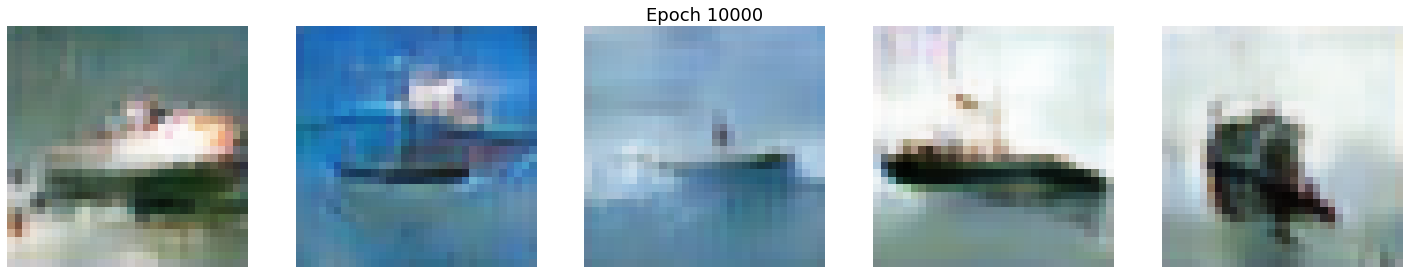

In [0]:
epoch_count = 0
for k in range(0, 21, 4):
    gen_images = gen_img_store[k]
    fig, axs = plt.subplots(1, 5)
    count = 0
    for j in range(5):
        axs[j].imshow(gen_images[count, :, :])
        count += 1
        axs[j].axis('off')
    axs[2].set_title("Epoch {}".format(epoch_count), fontsize = 18)
    epoch_count += 2000